# 1. Data preparation

## 1.1 loading packages

In [ ]:
 pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import math
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import xgboost

from sklearn import metrics
from sklearn.impute import KNNImputer 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from dmba import classificationSummary, adjusted_r2_score, AIC_score, BIC_score, gainsChart, liftChart

## 1.2 loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/UIUC/BADM557 team7/Health Insurance Lead Prediction Raw Data.csv")
df.shape

(50882, 14)

In [ ]:
df.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [ ]:
df.describe()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
count,50882.000000,50882.000000,50882.000000,50882.000000,30631.000000,50882.000000,50882.000000,50882.000000
mean,25441.500000,1732.788707,44.856275,42.738866,2.439228,15.115188,14183.950069,0.239947
std,14688.512535,1424.081652,17.310271,17.319375,1.025923,6.340663,6590.074873,0.427055
min,1.000000,1.000000,18.000000,16.000000,1.000000,1.000000,2280.000000,0.000000
25%,12721.250000,523.000000,28.000000,27.000000,1.000000,12.000000,9248.000000,0.000000
50%,25441.500000,1391.000000,44.000000,40.000000,3.000000,17.000000,13178.000000,0.000000
75%,38161.750000,2667.000000,59.000000,57.000000,3.000000,20.000000,18096.000000,0.000000
max,50882.000000,6194.000000,75.000000,75.000000,4.000000,22.000000,43350.400000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

# 2. Exploratory data analysis

## 2.1Missing value

In [ ]:
# percentage of null values of each feature
feature_nulls = (df.isnull().sum() / df.shape[0])*100
feature_nulls

ID                          0.000000
City_Code                   0.000000
Region_Code                 0.000000
Accomodation_Type           0.000000
Reco_Insurance_Type         0.000000
Upper_Age                   0.000000
Lower_Age                   0.000000
Is_Spouse                   0.000000
Health Indicator           22.976691
Holding_Policy_Duration    39.799929
Holding_Policy_Type        39.799929
Reco_Policy_Cat             0.000000
Reco_Policy_Premium         0.000000
Response                    0.000000
dtype: float64

In [ ]:
df['Health Indicator'].value_counts()

X1    13010
X2    10332
X3     6762
X4     5743
X5     1727
X6     1280
X7      196
X8       78
X9       63
Name: Health Indicator, dtype: int64

As there are around 40% null values, we will omit the variables Holding_Policy_Duration and Holding_Policy_Type

## 2.2 Heatmap

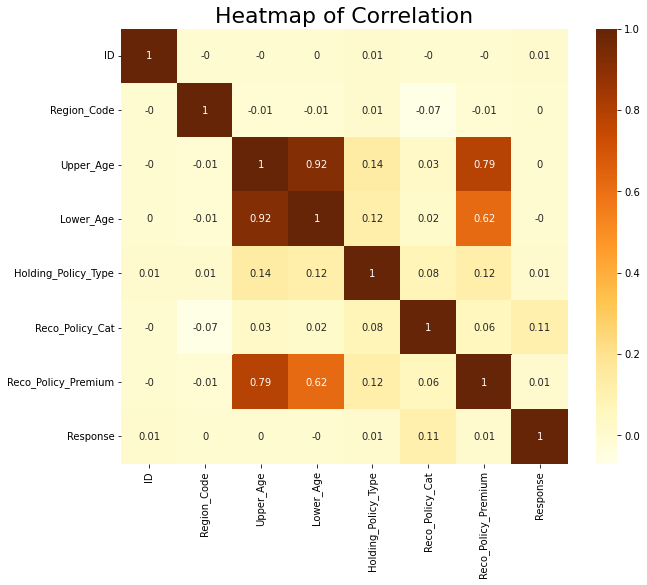

In [ ]:
df_corr = df.corr().round(2)
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='YlOrBr')
plt.title('Heatmap of Correlation',fontsize=22)
plt.show()

From the heatmap, there are two noticeable points:

*   there is a strong correlation between the Lower_Age variable and the Upper_Age variable,
*   Upper_Age variable has a considerable correlation with the Reco_Policy_Premium variable,

so we can remove the Upper_Age variable and solve the correlation problem.

In [ ]:
df = df.drop(columns='Upper_Age')
df

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,No,X2,3.0,1.0,16,10404.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50877,50878,C4,845,Rented,Individual,22,No,X3,NaN,NaN,18,7704.0,0
50878,50879,C5,4188,Rented,Individual,27,No,X3,7.0,3.0,4,5408.0,0
50879,50880,C1,442,Rented,Individual,63,No,X2,14+,1.0,12,11374.0,0
50880,50881,C1,4,Owned,Joint,49,No,X2,2.0,2.0,16,28179.2,1


# 3. Features Selection & Data Preparation

### 3.1 Catgorical & numerial

In [ ]:
df = df.drop(columns='ID')

In [ ]:
# convert numeric to categorical viariables
df['Region_Code'] = df['Region_Code'].astype('category')
df['Holding_Policy_Type'] = df['Holding_Policy_Type'].astype('category')
df['Reco_Policy_Cat'] = df['Reco_Policy_Cat'].astype('category')

In [ ]:
num_col_names = df.select_dtypes(include=np.number).columns.tolist()
cat_col_names = [cat for cat in df.columns if cat not in num_col_names]
print(num_col_names)
print(cat_col_names)

['Lower_Age', 'Reco_Policy_Premium', 'Response']
['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat']


## 3.1 Missing value

In [ ]:
df.isnull().sum()

City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

In [ ]:
# percentage of null values of each feature
feature_nulls = (df.isnull().sum() / df.shape[0])*100
feature_nulls

City_Code                   0.000000
Region_Code                 0.000000
Accomodation_Type           0.000000
Reco_Insurance_Type         0.000000
Lower_Age                   0.000000
Is_Spouse                   0.000000
Health Indicator           22.976691
Holding_Policy_Duration    39.799929
Holding_Policy_Type        39.799929
Reco_Policy_Cat             0.000000
Reco_Policy_Premium         0.000000
Response                    0.000000
dtype: float64

As there are around 40% null values, we will omit the variables Holding_Policy_Duration and Holding_Policy_Type

In [ ]:
df = df[df['Holding_Policy_Duration'].notnull()]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30631 entries, 0 to 50881
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   City_Code                30631 non-null  object  
 1   Region_Code              30631 non-null  category
 2   Accomodation_Type        30631 non-null  object  
 3   Reco_Insurance_Type      30631 non-null  object  
 4   Lower_Age                30631 non-null  int64   
 5   Is_Spouse                30631 non-null  object  
 6   Health Indicator         23548 non-null  object  
 7   Holding_Policy_Duration  30631 non-null  object  
 8   Holding_Policy_Type      30631 non-null  category
 9   Reco_Policy_Cat          30631 non-null  category
 10  Reco_Policy_Premium      30631 non-null  float64 
 11  Response                 30631 non-null  int64   
dtypes: category(3), float64(1), int64(2), object(6)
memory usage: 2.6+ MB


We need to do data imputation or just omit the missing data of 'health indicator' since it has 23% missing values.

In [ ]:
df['Health Indicator'].value_counts()

X1    7682
X2    6252
X3    3912
X4    3638
X5    1141
X6     700
X7     133
X8      54
X9      36
Name: Health Indicator, dtype: int64

Though x1 and x2 have the dominant numbers, we can't simply use the mode to impute since it would trigger bias. Therefore, we keep the NA in 'health indicator'.

## 3.3 Dummy & X,y

In [ ]:
df['Response'].value_counts()

0    23261
1     7370
Name: Response, dtype: int64

In [ ]:
7370/(23261+ 7370)
# 24% is good, no need for balancing data
# data imbalance

0.24060592210505696

In [ ]:
def GetXY_dummy(df, features, cat_features):
    '''
    Select the subset of features
    Create dummy variables if needed
    '''
    df = df.loc[:, features]

    for cat_feature in cat_features:
        if cat_feature in df.columns:
            df = pd.get_dummies(df, prefix = [cat_feature], columns = [cat_feature], drop_first = True)
           
    X = df.drop(['Response'], axis = 1)
    y = df['Response']
   
    return X, y

# features: list of all features, use lst below
# outcome: y-variable

In [ ]:
X, y = GetXY_dummy(df=df,features=df.columns,cat_features=cat_col_names)
X.shape,len(y)

((30631, 5401), 30631)

## 3.4 Optimazing Models

### 3.4.1 Balancing classes(optional)

We can do banlancing classes to see if the model would perform better. However, we don't want to do that in the first place.

```
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)
ax = sns.countplot(x=y)
```



### 3.4.2 Normalization(optional)

We will run the models before scaling the data, and go back here to try StandardScaler or MinMaxScaler and verify if we have best results using the scaling.


```
# StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
obj_norm = MinMaxScaler().fit(X)
X_normalization = obj_norm.transform(X)
```



##3.5 Splitting dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
X_train.shape, len(y_train)

((21441, 5401), 21441)

In [ ]:
X_test.shape, len(y_test)

((9190, 5401), 9190)

#4. Model Building

## 4.1 Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

### Running Model

In [ ]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred_nb = naive_bayes.predict(X_test)

In [ ]:
y_proba_nb = naive_bayes.predict_proba(X_test)

### Performance

In [ ]:
# Compute confusion matrix for test set
confusion_nb = confusion_matrix(y_test, y_pred_nb)
confusion_nb

array([[6333,  729],
       [1756,  372]])

In [ ]:
# Testing summary 
print(metrics.classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84      7062
           1       0.34      0.17      0.23      2128

    accuracy                           0.73      9190
   macro avg       0.56      0.54      0.53      9190
weighted avg       0.68      0.73      0.70      9190



In [ ]:
# accuracy score
accuracy_score(y_test, y_pred_nb)

0.7295973884657236

Naive Bayes give accuracy as 0.7307 using data without any scaling.

## 4.2 Decision Tree

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

### Running Model

In [ ]:
decision_tree = DecisionTreeClassifier(criterion = 'gini', min_samples_split = 5, max_depth= 6, random_state=42)

In [ ]:
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_split=5, random_state=42)

In [ ]:
y_pred_dt = decision_tree.predict(X_test)

In [ ]:
y_proba_dt = decision_tree.predict_proba(X_test)

### Performance

In [ ]:
# Compute confusion matrix for test set
confusion_dt = confusion_matrix(y_test, y_pred_dt)
confusion_dt

array([[6941,  121],
       [2011,  117]])

In [ ]:
# Testing summary 
print(metrics.classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      7062
           1       0.49      0.05      0.10      2128

    accuracy                           0.77      9190
   macro avg       0.63      0.52      0.48      9190
weighted avg       0.71      0.77      0.69      9190



In [ ]:
# accuracy score
accuracy_score(y_test, y_pred_dt)

0.7680087051142547

## 4.3 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

### Running Model

In [ ]:
random_forest = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)

In [ ]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [ ]:
y_pred_rf = random_forest.predict(X_test)

In [ ]:
y_proba_rf = random_forest.predict_proba(X_test)

### Performance

In [ ]:
# Compute confusion matrix for test set
confusion_rf = confusion_matrix(y_test, y_pred_rf)
confusion_rf

array([[6966,   96],
       [2043,   85]])

In [ ]:
# Testing summary 
print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.77      0.99      0.87      7062
           1       0.47      0.04      0.07      2128

    accuracy                           0.77      9190
   macro avg       0.62      0.51      0.47      9190
weighted avg       0.70      0.77      0.68      9190



In [ ]:
# accuracy score
accuracy_score(y_test, y_pred_rf)

0.767247007616975

## 4.4 Logistic Regression

Logistic Regression doesn't work with na. Therefore, we impute data using mode in particular for this model.

In [ ]:
df_log = df.copy()
df_log['Health Indicator'].value_counts()

X1    7682
X2    6252
X3    3912
X4    3638
X5    1141
X6     700
X7     133
X8      54
X9      36
Name: Health Indicator, dtype: int64

In [ ]:
df_log['Health Indicator']=df_log['Health Indicator'].fillna(df_log['Health Indicator'].mode()[0])

In [ ]:
X_log, y_log = GetXY_dummy(df=df_log,features=df_log.columns,cat_features=cat_col_names)
X_log.shape,len(y_log)

((30631, 5401), 30631)

In [ ]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size = 0.3, random_state = 42)

In [ ]:
X_train_log.shape, len(y_train_log)

((21441, 5401), 21441)

In [ ]:
X_test_log.shape, len(y_test_log)

((9190, 5401), 9190)

In [ ]:
from sklearn.linear_model import LogisticRegression

### Running Model

In [ ]:
logistic = LogisticRegression(random_state = 42)

In [ ]:
logistic.fit(X_train_log, y_train_log)

LogisticRegression(random_state=42)

In [ ]:
y_pred_log = logistic.predict(X_test_log)

In [ ]:
y_proba_log = logistic.predict_proba(X_test_log)

### Performance

In [ ]:
# Compute confusion matrix for test set
confusion_log = confusion_matrix(y_test_log, y_pred_log)
confusion_log

array([[7062,    0],
       [2128,    0]])

In [ ]:
# Testing summary 
print(metrics.classification_report(y_test_log, y_pred_log))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      7062
           1       0.00      0.00      0.00      2128

    accuracy                           0.77      9190
   macro avg       0.38      0.50      0.43      9190
weighted avg       0.59      0.77      0.67      9190



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# accuracy score
accuracy_score(y_test, y_pred_log)

0.7684439608269859

## 4.5 K Nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

### Running Model

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 8, metric = 'minkowski', p = 2)

In [ ]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

In [ ]:
y_pred_knn = knn.predict(X_test)

In [ ]:
y_proba_knn = knn.predict_proba(X_test)

### Performance

In [ ]:
# Compute confusion matrix for test set
confusion_knn = confusion_matrix(y_test, y_pred_knn)
confusion_knn

array([[6885,  177],
       [2080,   48]])

In [ ]:
# Testing summary 
print(metrics.classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      7062
           1       0.21      0.02      0.04      2128

    accuracy                           0.75      9190
   macro avg       0.49      0.50      0.45      9190
weighted avg       0.64      0.75      0.67      9190



In [ ]:
# accuracy score
accuracy_score(y_test, y_pred_knn)

0.7544069640914037

# 5. Conclusion

In [ ]:
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plot subplot for precision
    plt.subplot(1, 2, 1)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)
        print("Normalized confusion matrix precision")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Precision for '+title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
   

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   
   
    #plot subplot for recall
    plt.subplot(1, 2, 2)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix recall")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Recall for '+title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
   

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[6987   75]
 [2048   80]]
Confusion matrix, without normalization
[[6987   75]
 [2048   80]]


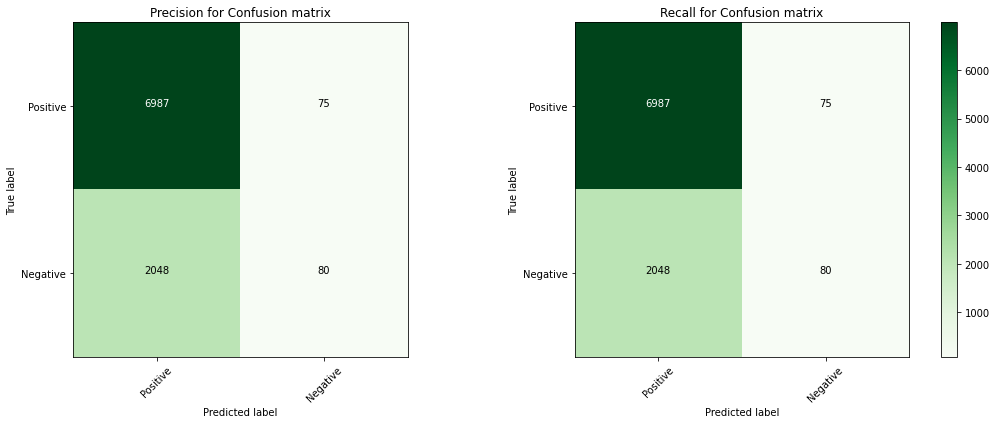

In [ ]:
# Compute confusion matrix for training set
# random forest confusion matrix
cf_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
np.set_printoptions(precision=2)
plt.figure(figsize=(16,6))
class_names = ["Positive","Negative"]
plot_confusion_matrix(cf_matrix, classes=class_names)
plt.show()

In [ ]:
#Plotting lift and gain chart 
%matplotlib inline 
def plot_lift_gain(model, y_test, y_pred, y_proba):
  model_reslut = pd.DataFrame({'actual': y_test, 
                            'p(0)': [p[0] for p in y_proba], 
                            'p(1)': [p[1] for p in y_proba],
                            'predicted': y_pred})
  df = model_reslut.sort_values(by=['p(1)'], ascending=False)
  fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

  gainsChart(df.actual, ax=axes[0])
  liftChart(df['p(1)'], title=False, ax=axes[1])

  plt.tight_layout()
  plt.show()

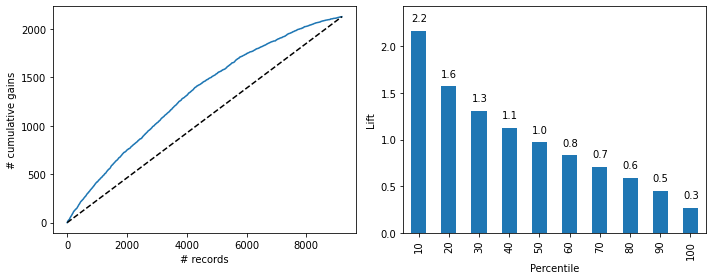

In [ ]:
# random forest ROC-AUC curve
plot_lift_gain(random_forest, y_test, y_pred_rf,y_proba_rf)

In [ ]:
feature_importance = pd.DataFrame({'Feature': list(X_train.columns), 'Importance':random_forest.feature_importances_})
feature_importance.sort_values(by='Importance',ascending=False, inplace=False)

,Feature,Importance
1,Reco_Policy_Premium,0.079271
0,Lower_Age,0.070605
5352,Accomodation_Type_Rented,0.015950
5355,Health Indicator_X2,0.014046
5378,Holding_Policy_Type_3.0,0.012756
...,...,...
4088,Region_Code_4605,0.000000
4860,Region_Code_5468,0.000000
4861,Region_Code_5469,0.000000
4862,Region_Code_5470,0.000000


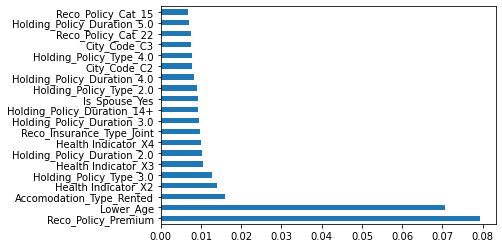

In [ ]:
feat_importances = pd.Series(random_forest.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')